In [2]:
import numpy as np
# import pathogenprofiler as pp
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
# import fastq2matrix as fm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
from scipy.stats import norm
import subprocess
from scipy.stats import kurtosis, skew
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from cb91visuals import *
import gc
import pipe



In [1]:
vcf_file = '../test_data/ERR6634978-ERR6635032-5050.vcf.gz' #file used creating the model
json_file = '../test_data/ERR6634978-ERR6635032-5050.results.json' #file used for targeting and error checking
bam_file = "../test_data/ERR6634978-ERR6635032-2575.mkdup.bam" #file used for finding reads pos and len for locating anchored snps

In [3]:
VCF_FILE_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/'
#/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/q20
JSON_FILE_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/results'
#/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/q20/results

NAME_FILE='/mnt/storage7/lwang/trial_tb_philippines/data/seqtk/sample_name.txt'


In [4]:
with open('fst_results_clean_fst_1_for_paper.csv','r') as f:
    barcode = []
    for line in f:
        data_line = line.rstrip().split(',')
        data_line = [i for i in data_line]
        barcode.append(data_line)

df_bar = pd.DataFrame(barcode)
df_bar = df_bar.iloc[1:, :8]
df_bar.drop([0,3,4,5,6], axis=1, inplace=True)





In [5]:
with open('read_pos.csv', 'w') as f:
    subprocess.run("samtools view %s | awk '{print $4 ',' $4+length($10)-1}'" %bam_file, shell=True, stdout=f, text=True)
    #this extracts data from bam file in the format of read start position and read end position

with open('read_pos.csv', 'r') as f:
    read_data = []
    for line in f:
        data_line = line.rstrip().split('\n')
        data_line = data_line[0].split(' ')
        data_line = [i for i in data_line]
        read_data.append(data_line)

read_data_df = pd.DataFrame(read_data, columns=['start_pos', 'end_pos'])
read_data_df.groupby(["start_pos"], as_index=False, sort=False)
#above are the effort to obtain start and stop positions of each read, but couldn't perform groupby for some reason

In [6]:
# get data from vcf.gz file and export them as txt so that they can be read in a data frame function
def anchor(VCF_PATH):
    #load vcf
    with open('ROAO_DP_ALT.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '[%%POS,%%REF,%%ALT,%%GT,%%AD,%%DP\\n]'" %vcf_file, shell=True, stdout=f, text=True)
        #%%AD meaning the total read depth for each allele.
    with open('ROAO_DP_ALT.csv', 'r') as f:
        data = []
        num_col=0
        for line in f:
            data_line = line.rstrip().split('\n')
            data_line = data_line[0].split(',')
            data_line = [i for i in data_line]
            if len(data_line) > num_col:
                num_col = len(data_line)
            data.append(data_line)
                

    with open('fst_results_clean_fst_1_for_paper.csv','r') as f:
        barcode = []
        for line in f:
            data_line = line.rstrip().split(',')
            data_line = [i for i in data_line]
            barcode.append(data_line)

    df_bar = pd.DataFrame(barcode)
    df_bar = df_bar.iloc[1:, :8]
    df_bar.drop([0,3,4,5,6], axis=1, inplace=True)

    df_bar_array = np.array(df_bar)

    #load data vcf and get the anchored SNPs
    data1 = []

    for i in data:
        if len(i) == 7: #restrict length of each list in the large list is 7 so that we only accounts for snps with only one alternative
            data1.append(i)
    data1_array = np.array(data1)

    data1_array = np.delete(data1_array, 3, 1) #remove genotype data in 3 from the data

    anchored = [] #if the snp reading position from sample that is located within the range suggest in entries of gary's database
    for x in data1_array:
        for y in df_bar_array:
            # if int(x[0]) >= int(y[1])-150 and int(x[0]) < int(y[1])+150 and x[2] == y[2]: 
                #the read length is of 150bps from hi seq illumina, therefore +/- 150bps is likely on the same read, 
                #read that are on the same read as the anchor read can be automatically assigned to the strain
                #data formate of the insert: [pos, ref, alt, ref read count, alt read count, total count, lineage]
            if int(x[0]) >= int(y[1]) and int(x[0]) < int(y[1])+1 and x[2] == y[2]: 
                #alternatively range within the length of the snp is used to find anchored snps.

                insert = np.append(x, y[0])
                anchored.append(insert)
                

                # anchored_array = np.array(anchored)
                # anchored_lineage = anchored_array[:, 6] #lineage column
                # # anchored_lineage = anchored_lineage.astype(float)

                # anchored_snp = anchored_array[:, 3:5] #snp column
                # anchored_snp = anchored_snp.astype(float)

    return anchored, data1_array     
      
anchored, data1_array= anchor(vcf_file)

In [7]:
anchored_df = pd.DataFrame(anchored, columns=["pos", "ref", "alt", "ref_dp", "alt_dp", "total_dp", "lineage"])

anchored_df

,pos,ref,alt,ref_dp,alt_dp,total_dp,lineage
0,9260,G,C,103,82,185,1.2.1
1,13175,A,G,103,61,164,1.2.1.2
2,14251,G,A,76,80,156,4.3
3,15088,C,T,88,71,159,1.2.1.2
4,22961,T,G,101,78,179,1
...,...,...,...,...,...,...,...
733,4399137,G,A,84,66,150,1.2.1.2.1
734,4401400,A,G,74,54,129,1
735,4403900,A,G,129,128,257,4.3.4.2
736,4407588,T,C,91,80,171,4


In [8]:
anchored_df.sort_values(by="lineage")
anchored_df["lineage_cat"] = anchored_df["lineage"].astype('category').cat.codes

In [9]:
anchored_df.sort_values(by="lineage_cat", ascending = True)
anchored_df

,pos,ref,alt,ref_dp,alt_dp,total_dp,lineage,lineage_cat
0,9260,G,C,103,82,185,1.2.1,1
1,13175,A,G,103,61,164,1.2.1.2,2
2,14251,G,A,76,80,156,4.3,5
3,15088,C,T,88,71,159,1.2.1.2,2
4,22961,T,G,101,78,179,1,0
...,...,...,...,...,...,...,...,...
733,4399137,G,A,84,66,150,1.2.1.2.1,3
734,4401400,A,G,74,54,129,1,0
735,4403900,A,G,129,128,257,4.3.4.2,7
736,4407588,T,C,91,80,171,4,4


In [10]:
anchored_df['ref_dp'] = anchored_df['ref_dp'].astype(float)
anchored_df['alt_dp'] = anchored_df['alt_dp'].astype(float)

In [11]:
anchored_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pos          738 non-null    object 
 1   ref          738 non-null    object 
 2   alt          738 non-null    object 
 3   ref_dp       738 non-null    float64
 4   alt_dp       738 non-null    float64
 5   total_dp     738 non-null    object 
 6   lineage      738 non-null    object 
 7   lineage_cat  738 non-null    int8   
dtypes: float64(2), int8(1), object(5)
memory usage: 41.2+ KB


/tmp/ipykernel_82365/3957450345.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, orientation = 'vertical')
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu


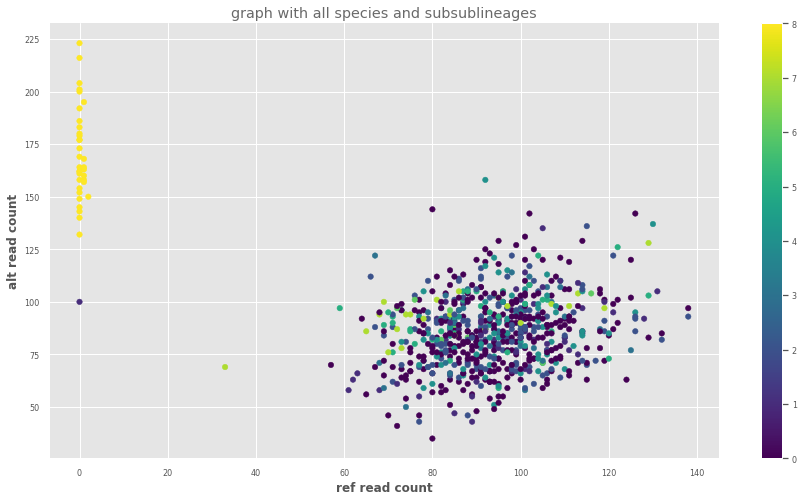

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

with plt.style.context('ggplot'):

   fig, ax = plt.subplots()
   # plt.figure(figsize=(25, 22))
   # for g in np.unique(group):
   #    ix = np.where(group == g)
   im = ax.scatter(anchored_df["ref_dp"], anchored_df["alt_dp"], c=anchored_df['lineage_cat'], cmap = "viridis", s = 30)
   ax.set_xlabel("ref read count")
   ax.set_ylabel("alt read count")
   ax.set_title("graph with all species and subsublineages")
   fig.colorbar(im, orientation = 'vertical')
   plt.show()

In [13]:
#removing extra sublineage info

list_ = []
for x in anchored_df['lineage']:
    if re.search("^[1-9]", x):
        x_sep = x.rstrip().split('.')
        list_.append(x_sep[0])
    else:
        list_.append(x)
anchored_df["lineage_main"] = list_
anchored_df['lineage_main'] = anchored_df['lineage_main'].astype(float)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_82365/1768654094.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, orientation = 'vertical')


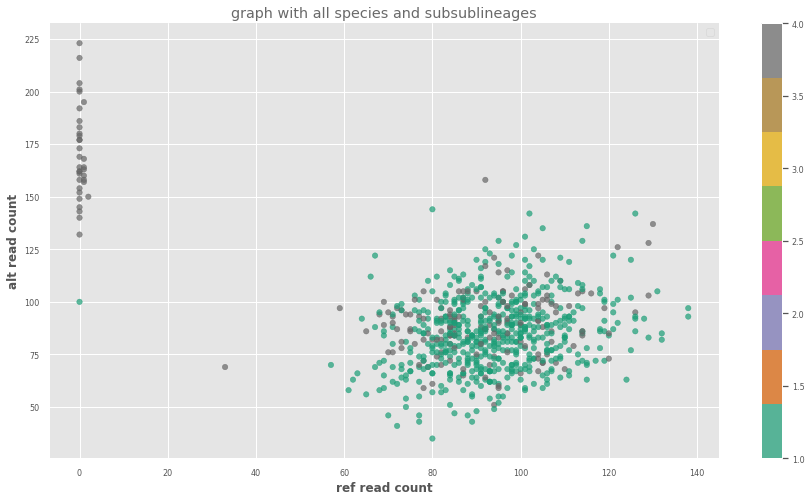

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

with plt.style.context('ggplot'):

   fig, ax = plt.subplots()
   # plt.figure(figsize=(25, 22))
   # for g in np.unique(group):
   #    ix = np.where(group == g)
   im = ax.scatter(anchored_df["ref_dp"], anchored_df["alt_dp"], c=anchored_df['lineage_main'], cmap = "Dark2", alpha=0.7, s = 30)
   ax.legend()
   ax.set_xlabel("ref read count")
   ax.set_ylabel("alt read count")
   ax.set_title("graph with all species and subsublineages")
   fig.colorbar(im, orientation = 'vertical')
   plt.show()

In [15]:
def assign_variant_to_distrib(gm,freq,cutoff=0.95):
    probs = gm.predict_proba([[freq]])
    pred = gm.predict([[freq]])
    if probs[0][pred][0]>cutoff: #put the prediction probability through cutoff threshold
        return pred[0], probs[0][pred][0]
    else:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        return None, pred[0], probs[0][pred][0]

In [16]:
tb_profiler_predictions = []
#tb-profiler predition reading extraction - used as target
def tb_profiler_pred(json_file):
    output = []
    json_results = json.load(open(json_file))
    for x in json_results['lineage']:
        if re.search("^lineage1.2.1$", x['lin']):
            output.append(x['frac'])
        if re.search("^lineage4.3.4$", x['lin']):
            output.append(x['frac'])

    #selecting cut off value automiatically
    if len(output) == 1:
        output.append(0)
    if output[0] < output[1]:
        temp = output[0]
        output[0] = output[1]
        output[1] = temp
    if output[0] > output[1]: 
        cut_off =  output[1]/2  #set cut off value to half of percentage of the strain with smaller proportion
    else:
        cut_off =  output[-2]/2

    return output, cut_off


print(tb_profiler_pred(json_file))

([0.5011990407673861, 0.47477064220183485], 0.23738532110091742)


/tmp/ipykernel_82365/1253641263.py:59: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()
  CS.cmap.set_over('blue')
/tmp/ipykernel_82365/1253641263.py:60: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()
  CS.cmap.set_under('red')
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu


([0.4796686518493914, 0.4218039867217495], GaussianMixture(n_components=2, random_state=0))


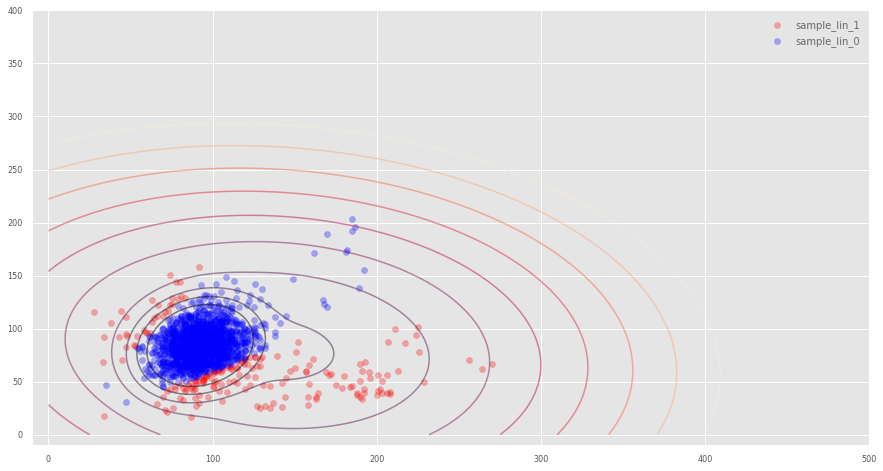

In [17]:
model_predictions = []

def model_pred(vcf_file, tail_cutoff=0.00, ratio='test'):
    with open('mix_infection.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe
    pos = []
    freqs = []
    scatter = []
    with open('mix_infection.csv', 'r') as f:
        for l in f:
            row = l.strip().split()
            ads = [int(x) for x in row[4].split(",")]
            afs = [x/sum(ads) for x in ads]
            if afs[1]>1-tail_cutoff or afs[1]<tail_cutoff: #apply cut off value
                continue
            pos.append(int(row[0]))
            freqs.append([afs[1]])
            scatter.append(ads)

        # freqs = [[0.7],[0.6],[0.4]]    
        gm = GaussianMixture(n_components=2, random_state=0).fit(freqs)
        mu0 = gm.means_[1][0]
        mu1 = gm.means_[0][0]
        
        scatter = np.array(scatter)
        
        labels = gm.predict(freqs)
        mu0_ = len(labels[labels==0])/len(labels)
        mu1_ = len(labels[labels==1])/len(labels)

        anchored_array = np.concatenate((scatter, labels.reshape(-1,1)), axis=1) 

        lin1_ = anchored_array[anchored_array[:,2]==1]
        lin4_ = anchored_array[anchored_array[:,2]==0]
        
    with plt.style.context('ggplot'):
        plt.figure()
        plt.scatter(lin1_[:,0], lin1_[:,1], c='red', alpha=0.3, label='sample_lin_1')
        plt.scatter(lin4_[:,0], lin4_[:,1], c='blue', alpha=0.3, label='sample_lin_0')
        plt.legend(title='sample_SNP', loc="upper right")
        plt.legend(frameon=False)
        plt.xlim(-10,500)
        plt.ylim(-10,400)

        
        #contour plot
        gm_contour = GaussianMixture(n_components=2, random_state=0).fit(scatter)
        x = np.arange(0, 500) #max/min of the ref&alt copy number from ROAOcsv
        y = x.reshape(-1,1)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -gm_contour.score_samples(XX)
        Z = Z.reshape(X.shape)


        CS = plt.contour(X,Y,Z, levels=np.logspace(1, 1.4, 10), extend='both', alpha=0.5) #level have max/min be the max/min of Z, same for norm
        CS.cmap.set_over('blue')
        CS.cmap.set_under('red')
        CS.changed()
        # CB = plt.colorbar(CS, shrink=0.8, extend="both")

    if mu0 > mu1:
        return [mu0, mu1], gm
    else:
        return [mu1, mu0], gm



print(model_pred(vcf_file, 0.14930838079739625))


In [18]:
def mse_cal(list1, list2):
    return mean_squared_error(list1, list2)

In [19]:
print(mse_cal([5011990407673861, 0.47477064220183485], [0.4796686518493914, 0.4218039867217495]))



1.2560023923307398e+31


In [20]:
X = anchored_df[["ref_dp","alt_dp"]].to_numpy().astype(float)
y = anchored_df["lineage_main"].to_numpy().reshape(-1, 1).astype(float)

In [21]:
#K nearest neighbour is attempted here to use the mater
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error


mse_list = []

# X[:,0] = (X[:,0] - np.mean(X[:,0])) / np.std(X[:,0])
# X[:,1] = (X[:,1] - np.mean(X[:,1])) / np.std(X[:,1])
# data1_array_test = np.array(data1_cutoff)[:,4:6].astype(float)

data1_array_test = np.array(data1_array)[:,3:5].astype(float)

# data1_array_test[:,1] = (data1_array_test[:,1] - np.mean(data1_array_test[:,1])) / np.std(data1_array_test[:,1])
# data1_array_test[:,2] = (data1_array_test[:,1] - np.mean(data1_array_test[:,2])) / np.std(data1_array_test[:,2])
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X, y)
    predictions = []
    for i in data1_array_test:
        pred = neigh.predict([i])
        predictions.append(pred[0])
        # X = np.append(X, i[1:3]).reshape(-1,2) #fiting predicted points back into model, doesn't really make a difference
        # y = np.append(y, pred).reshape(-1,1)
        # neigh.fit(X, y)

    lin1 = np.unique(predictions)[0]
    lin2 = np.unique(predictions)[1]

    pred_lin1 = predictions.count(lin1) / data1_array.shape[0]
    pred_lin2 = predictions.count(lin2) / data1_array.shape[0]

    y_true = [0.6681818181818182, 0.2986167615947925]
    y_pred = [pred_lin1, pred_lin2]

    mse = mean_squared_error(y_true, y_pred)
    mse_list.append(mse)


plt.plot(mse_list)

# print("lineage",lin1)
# print(pred_lin1)
# print("lineage",lin2)
# print(pred_lin2)

# predictions.reshape(-1, 1)



/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConv

KeyboardInterrupt: 

In [22]:
neigh = KNeighborsClassifier(n_neighbors=2, p=1)
neigh.fit(X, y)
predictions = []
for i in data1_array_test:
    pred = neigh.predict([i])
    predictions.append(pred[0])
    # X = np.append(X, i[1:3]).reshape(-1,2) #fiting predicted points back into model, doesn't really make a difference
    # y = np.append(y, pred).reshape(-1,1)
    # neigh.fit(X, y)

lin1 = np.unique(predictions)[0]
lin2 = np.unique(predictions)[1]

pred_lin1 = predictions.count(lin1) / data1_array.shape[0]
pred_lin2 = predictions.count(lin2) / data1_array.shape[0]

print(pred_lin1, pred_lin2)
print(mse_cal([5011990407673861, 0.47477064220183485],[pred_lin1, pred_lin2]))


/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.8022404136148212 0.1977595863851788
1.2560023923307392e+31


/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConv

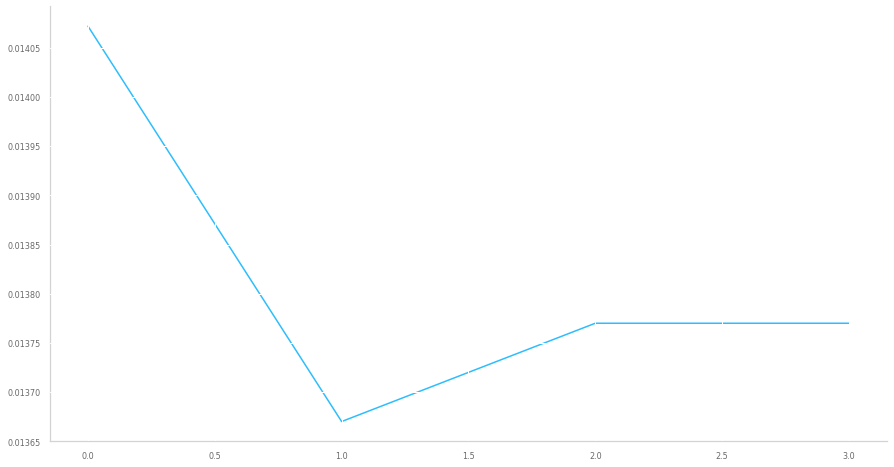

In [23]:
#K nearest neighbour is attempted here to use the mater
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error


mse_list = []

# X[:,0] = (X[:,0] - np.mean(X[:,0])) / np.std(X[:,0])
# X[:,1] = (X[:,1] - np.mean(X[:,1])) / np.std(X[:,1])
# data1_array_test = np.array(data1_cutoff)[:,4:6].astype(float)

data1_array_test = np.array(data1_array)[:,3:5].astype(float)

# data1_array_test[:,1] = (data1_array_test[:,1] - np.mean(data1_array_test[:,1])) / np.std(data1_array_test[:,1])
# data1_array_test[:,2] = (data1_array_test[:,1] - np.mean(data1_array_test[:,2])) / np.std(data1_array_test[:,2])
for p in range(1,5):
    neigh = KNeighborsClassifier(n_neighbors=2, p=p)
    neigh.fit(X, y)
    predictions = []
    for i in data1_array_test:
        pred = neigh.predict([i])
        predictions.append(pred[0])
        # X = np.append(X, i[1:3]).reshape(-1,2) #fiting predicted points back into model, doesn't really make a difference
        # y = np.append(y, pred).reshape(-1,1)
        # neigh.fit(X, y)

    lin1 = np.unique(predictions)[0]
    lin2 = np.unique(predictions)[1]

    pred_lin1 = predictions.count(lin1) / data1_array.shape[0]
    pred_lin2 = predictions.count(lin2) / data1_array.shape[0]

    y_true = [0.6681818181818182, 0.2986167615947925]
    y_pred = [pred_lin1, pred_lin2]

    mse = mean_squared_error(y_true, y_pred)
    mse_list.append(mse)


plt.plot(mse_list)

# print("lineage",lin1)
# print(pred_lin1)
# print("lineage",lin2)
# print(pred_lin2)

# predictions.reshape(-1, 1)



In [28]:
neigh = KNeighborsClassifier(n_neighbors=1, p=1)
neigh.fit(X, y)
predictions = []
for i in data1_array_test:
    pred = neigh.predict([i])
    predictions.append(pred[0])
    # X = np.append(X, i[1:3]).reshape(-1,2) #fiting predicted points back into model, doesn't really make a difference
    # y = np.append(y, pred).reshape(-1,1)
    # neigh.fit(X, y)

lin1 = np.unique(predictions)[0]
lin2 = np.unique(predictions)[1]

pred_lin1 = predictions.count(lin1) / data1_array.shape[0]
pred_lin2 = predictions.count(lin2) / data1_array.shape[0]

print(pred_lin1, pred_lin2)

print(mse_cal([0.6681818181818182, 0.2986167615947925],[pred_lin1, pred_lin2]))

/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.6596294700560104 0.34037052994398964
0.0009082599149117129


In [29]:
data1_df = pd.DataFrame(data1_array, columns=["pos", "ref", "alt", "ref_dp", "alt_dp", "total_dp"])
data1_df["knn_pred"] = predictions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_82365/4129915647.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, orientation = 'vertical')


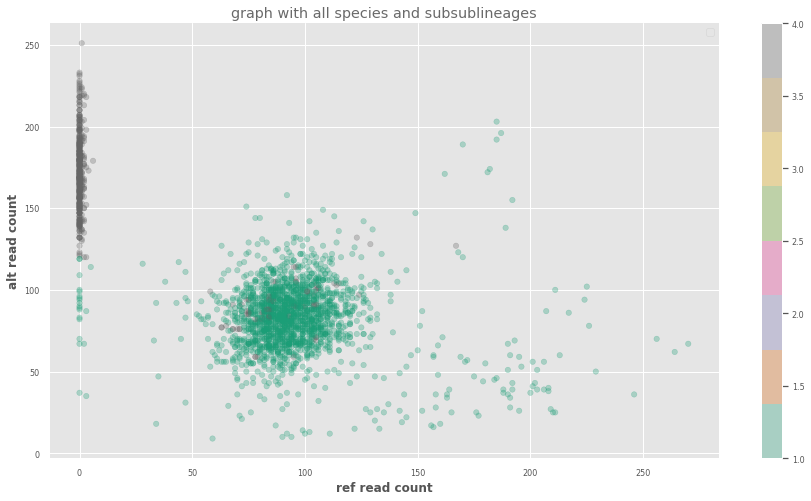

In [27]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

data1_df['ref_dp'] = data1_df['ref_dp'].astype(float)
data1_df['alt_dp'] = data1_df['alt_dp'].astype(float)

with plt.style.context('ggplot'):

   fig, ax = plt.subplots()
   # plt.figure(figsize=(25, 22))
   # for g in np.unique(group):
   #    ix = np.where(group == g)
   im = ax.scatter(data1_df["ref_dp"], data1_df["alt_dp"], c=data1_df['knn_pred'], cmap = "Dark2", alpha=0.3, s = 30)
   ax.legend()
   ax.set_xlabel("ref read count")
   ax.set_ylabel("alt read count")
   ax.set_title("graph with all species and subsublineages")
   fig.colorbar(im, orientation = 'vertical')
   plt.show()

In [121]:
def plot_f1_bar(ratio, f1, title='F1 score'):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ratio ,y=f1, mode='lines',))
    
    fig.update_layout(
        title=title,
        xaxis_title="Strain Ratio",
        yaxis_title="F1",
        legend_title="",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        )
    )
    
    fig.show()



# ratio, f1 = confusion_mat(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH)    

# plot_f1_bar(ratio, f1)

In [144]:
def frac_MSE_gmm(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH):
    with open(NAME_FILE, 'r') as f:
        sample_list = [line.rstrip('\n') for line in f]

    sample_list_json=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.results.json')
        string = ''.join([letter for letter in x] )
        sample_list_json.append(string)
    

    sample_list_vcf=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.vcf.gz')  #change here if using filtered/non-filtered samples
        string = ''.join([letter for letter in x] )
        sample_list_vcf.append(string)

    ratio = []
    for i in sample_list_json:
        temp = i.split('-')
        ratio.append(temp[2])
    
    ratio1=[]
    for i in ratio:
        temp = i.split('.')
        ratio1.append(temp[0])

    ratio = ratio1

    tb_profiler_predictions = []
    model_predictions = []

    for j, vcf, ratio in zip(sample_list_json, sample_list_vcf, ratio):
        JSON_FILE = os.path.join(JSON_FILE_PATH, j)
        tb_out_, cut_off = tb_profiler_pred(JSON_FILE)

        VCF_FILE = os.path.join(VCF_FILE_PATH, vcf)
#graphing for sample SNPs(using gary's database)
        model_out_, gm = model_pred(VCF_FILE, tail_cutoff=cut_off, ratio=ratio)

# #graphing for lineage specific snps found in the sample (using gary's database)
#         print(f'runing anchor for {ratio}')
#         anchored, data1_array = anchor(VCF_FILE)

#         anchored_array = np.concatenate((anchored_snp, anchored_lineage.reshape(-1,1)), axis=1) 

#         lin1_ = anchored_array[anchored_array[:,2]==1]
#         lin4_ = anchored_array[anchored_array[:,2]==4]

#         # plt.scatter(lin1_[:,0], lin1_[:,1], c='purple', alpha=0.7, label='signature_lin_1')
#         # plt.scatter(lin4_[:,0], lin4_[:,1], c='green', alpha=0.7, label='signature_lin_4')
#         plt.title(f'ratio: {ratio}')
#         # plt.legend(title="lineage specific SNPs",loc="upper right")
#         # plt.legend(frameon=False)


        tb_profiler_predictions.extend(tb_out_)
        model_predictions.extend(model_out_)
        print(f'{ratio}, done')
    
    print(tb_profiler_predictions)
    print(model_predictions)
    
    mse_ = []

    for tb, m in zip (tb_profiler_predictions, model_predictions):
        mse_.append(mean_squared_error([tb], [m], squared=False))

    # ratio1 = ['0100','0100[1]', '0595','0595[1]', '1000','1000[1]', '1090','1090[1]', '1585','1585[1]', '2080','2080[1]', 
    #           '2575','2575[1]', '3070','3070[1]', '3565','3565[1]', '4060','4060[1]', '4555','4555[1]', 
    #           '5050','5050[1]', '5545','5545[1]', '6040','6040[1]', '6535','6535[1]', '7030','7030[1]', 
    #           '7525','7525[1]', '8020','8020[1]', '8515','8515[1]', '9010','9010[1]', '9505','9505[1]']
    # print('len_ratio1', len(ratio1))
    # print('len_mse_', len(mse_))
    # print(mse_)
    # plot_f1_bar(ratio1, mse_, title='RMSE score')
    
    MSE = mean_squared_error(tb_profiler_predictions, model_predictions, squared=False)

    return mse_, MSE

In [142]:
def frac_MSE_knn(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH):
    with open(NAME_FILE, 'r') as f:
        sample_list = [line.rstrip('\n') for line in f]

    sample_list_json=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.results.json')
        string = ''.join([letter for letter in x] )
        sample_list_json.append(string)
    

    sample_list_vcf=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.vcf.gz')  #change here if using filtered/non-filtered samples
        string = ''.join([letter for letter in x] )
        sample_list_vcf.append(string)

    ratio = []
    for i in sample_list_json:
        temp = i.split('-')
        ratio.append(temp[2])
    
    ratio1=[]
    for i in ratio:
        temp = i.split('.')
        ratio1.append(temp[0])

    ratio = ratio1

    tb_profiler_predictions = []
    model_predictions = []

    for j, vcf, ratio in zip(sample_list_json, sample_list_vcf, ratio):
        JSON_FILE = os.path.join(JSON_FILE_PATH, j)
        tb_out_, cut_off = tb_profiler_pred(JSON_FILE)

        VCF_FILE = os.path.join(VCF_FILE_PATH, vcf)

        #graphing for sample SNPs(using gary's database)
        neigh = KNeighborsClassifier(n_neighbors=2, p=1)
        neigh.fit(X, y)
        predictions = []
        for i in data1_array_test:
            pred = neigh.predict([i])
            predictions.append(pred[0])
            # X = np.append(X, i[1:3]).reshape(-1,2) #fiting predicted points back into model, doesn't really make a difference
            # y = np.append(y, pred).reshape(-1,1)
            # neigh.fit(X, y)

        lin1 = np.unique(predictions)[0]
        lin2 = np.unique(predictions)[1]

        pred_lin1 = predictions.count(lin1) / data1_array.shape[0]
        pred_lin2 = predictions.count(lin2) / data1_array.shape[0]

        model_out_ = [pred_lin1, pred_lin2]
# #graphing for lineage specific snps found in the sample (using gary's database)
#         print(f'runing anchor for {ratio}')
#         anchored, data1_array = anchor(VCF_FILE)

#         anchored_array = np.concatenate((anchored_snp, anchored_lineage.reshape(-1,1)), axis=1) 

#         lin1_ = anchored_array[anchored_array[:,2]==1]
#         lin4_ = anchored_array[anchored_array[:,2]==4]

#         # plt.scatter(lin1_[:,0], lin1_[:,1], c='purple', alpha=0.7, label='signature_lin_1')
#         # plt.scatter(lin4_[:,0], lin4_[:,1], c='green', alpha=0.7, label='signature_lin_4')
#         plt.title(f'ratio: {ratio}')
#         # plt.legend(title="lineage specific SNPs",loc="upper right")
#         # plt.legend(frameon=False)


        tb_profiler_predictions.extend(tb_out_)
        model_predictions.extend(model_out_)
        print(f'{ratio}, done')
    
    print(tb_profiler_predictions)
    print(model_predictions)
    
    mse_ = []

    for tb, m in zip (tb_profiler_predictions, model_predictions):
        mse_.append(mean_squared_error([tb], [m], squared=False))

    # ratio1 = ['0100','0100[1]', '0595','0595[1]', '1000','1000[1]', '1090','1090[1]', '1585','1585[1]', '2080','2080[1]', 
    #           '2575','2575[1]', '3070','3070[1]', '3565','3565[1]', '4060','4060[1]', '4555','4555[1]', 
    #           '5050','5050[1]', '5545','5545[1]', '6040','6040[1]', '6535','6535[1]', '7030','7030[1]', 
    #           '7525','7525[1]', '8020','8020[1]', '8515','8515[1]', '9010','9010[1]', '9505','9505[1]']
    # print('len_ratio1', len(ratio1))
    # print('len_mse_', len(mse_))
    # print(mse_)
    # plot_f1_bar(ratio1, mse_, title='RMSE score')
    
    MSE = mean_squared_error(tb_profiler_predictions, model_predictions, squared=False)

    return mse_, MSE

<h1>MSE

In [ ]:
mse_knn, MSE_knn = frac_MSE_knn(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH)

In [145]:
ratio1 = ['0100','0100[1]', '0595','0595[1]', '1000','1000[1]', '1090','1090[1]', '1585','1585[1]', '2080','2080[1]', 
          '2575','2575[1]', '3070','3070[1]', '3565','3565[1]', '4060','4060[1]', '4555','4555[1]', 
          '5050','5050[1]', '5545','5545[1]', '6040','6040[1]', '6535','6535[1]', '7030','7030[1]', 
          '7525','7525[1]', '8020','8020[1]', '8515','8515[1]', '9010','9010[1]', '9505','9505[1]']

fig = go.Figure()
fig.add_trace(go.Scatter(x=ratio1 ,y=mse_knn, mode='lines',))

fig.update_layout(
    title="RMSE",
    xaxis_title="Strain Ratio",
    yaxis_title="F1",
    legend_title="",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
mse_gmm, MSE_gmm  = frac_MSE_gmm(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH)

In [148]:
ratio1 = ['0100','0100[1]', '0595','0595[1]', '1000','1000[1]', '1090','1090[1]', '1585','1585[1]', '2080','2080[1]', 
          '2575','2575[1]', '3070','3070[1]', '3565','3565[1]', '4060','4060[1]', '4555','4555[1]', 
          '5050','5050[1]', '5545','5545[1]', '6040','6040[1]', '6535','6535[1]', '7030','7030[1]', 
          '7525','7525[1]', '8020','8020[1]', '8515','8515[1]', '9010','9010[1]', '9505','9505[1]']

fig = go.Figure()
fig.add_trace(go.Scatter(x=ratio1 ,y=mse_gmm, mode='lines',))
fig.add_trace(go.Scatter(x=ratio1 ,y=mse_knn, mode='lines',))

fig.update_layout(
    title="RMSE",
    xaxis_title="Strain Ratio",
    yaxis_title="F1",
    legend_title="",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
#removing the 0100 and 1000 6040, 5050case
y_true = [0.8633651551312649, 0.1011378002528445, 0.7554125219426565, 0.20933977455716588, 0.6681818181818182, 0.2986167615947925, 
          # 0.5873648264086511, 0.3963963963963964, 0.5011990407673861, 0.47477064220183485, 0.5932203389830508, 0.38841567291311757, 
          0.6951219512195121, 0.2962962962962963, 0.7953216374269005, 0.20057803468208094, 0.9061461794019934, 0.12028608582574772]
y_pred = [0.7660500659768188, 0.23408824816297552, 0.7659220199852712, 0.2368329200364438, 0.7633326746158897, 0.248175728926683, 
          # 0.7502904174077132, 0.2759160643977226, 0.7268216992632079, 0.3190932149543465, 0.7520835761491568, 0.2726061158130421, 
          0.7637465557502369, 0.24760025372757327, 0.7659445772369651, 0.2352338544977916, 0.7660500659768188, 0.23408824816297552]
print(len(y_true))
print(len(y_pred))
mean_squared_error(y_true, y_pred, squared=False)

<h1>Confusion matrix

In [118]:
def confusion_map(y, y_pred, title):
    cf_matrix = confusion_matrix(y, y_pred)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure()
    plt.title(title)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [119]:
# confusion matrix for drug resistance
def confusion_mat(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH, output=False):
    with open(NAME_FILE, 'r') as f:
        sample_list = [line.rstrip('\n') for line in f]

    sample_list_json=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.results.json')
        string = ''.join([letter for letter in x] )
        sample_list_json.append(string)
        
    sample_list_vcf=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.vcf.gz')
        string = ''.join([letter for letter in x] )
        sample_list_vcf.append(string)

    ratio = []
    for i in sample_list_json:
        temp = i.split('-')
        ratio.append(temp[2])
    
    ratio1=[]
    for i in ratio:
        temp = i.split('.')
        ratio1.append(temp[0])

    ratio = ratio1

    pos_lin_0 = {'rifampicin':0, 'isoniazid':1, 'ethambutol':2}
    pos_lin_1 = {'rifampicin':0, 'streptomycin':1, 'isoniazid':2, 'ethionamide':3}
    
    ratio_list = []
    f1_list = []



    for j, vcf, ratio in zip(sample_list_json, sample_list_vcf, ratio):
        JSON_FILE = os.path.join(JSON_FILE_PATH, j)
        tb_out_, cut_off = tb_profiler_pred(JSON_FILE)

        if ratio == '0100': 
            lin_ = [0,0,0,1,1,1,1] #lineage1 with rifampicin, streptomycin, isoniazid, ethionamide resistance
        elif ratio == '1000':
            lin_ = [1,1,1,0,0,0,0] #lineage4 with rifampicin, isoniazid, ethambutol resistance
        else:
            lin_ = [1,1,1,1,1,1,1]


        VCF_FILE = os.path.join(VCF_FILE_PATH, vcf)
        model_out_, gm = model_pred(VCF_FILE, tail_cutoff=cut_off)

        strain0 = []
        strain1 = []
        strainU = []

        json_results = json.load(open(JSON_FILE))
        for var in json_results['dr_variants']:
            cluster = assign_variant_to_distrib(gm,var['freq'], cutoff=0.95)
            if cluster[0] == 0:
                var['probs']= cluster
                strain0.append(var)
            elif cluster[0] == 1:
                var['probs']= cluster
                strain1.append(var)
            else:
                var['probs']= cluster[1:]
                strainU.append(var)


        strain_0 = [(v['drugs'][0]['drug']) for v in strain0]
        strain_1 = [(v['drugs'][0]['drug']) for v in strain1]
        
        # print(ratio)
        # print(strain_0)
        # print(strain_1)
        
        if 'ethambutol' in strain_1:
            strain_0 = [(v['drugs'][0]['drug']) for v in strain1]
            strain_1 = [(v['drugs'][0]['drug']) for v in strain0]

        if 'streptomycin' in strain_0 or 'ethionamide' in strain_0:
            strain_1 = [(v['drugs'][0]['drug']) for v in strain0]
            strain_0 = [(v['drugs'][0]['drug']) for v in strain1]

        # strain_0 = list(set(strain_0))
        # strain_1 = list(set(strain_1))
        
        # print(ratio)
        # print(strain_0)
        # print(strain_1)
        
        strain_0_pred = [0]*3
        if 'streptomycin' in strain_0 or 'ethionamide' in strain_0:
            print(ratio,'strain_0_error', strain_0)
        else:
            for d in strain_0:
                strain_0_pred[pos_lin_0[d]] = 1

        strain_1_pred = [0]*4
        if 'ethambutol' in strain_1:
            print(ratio,'strain_1_error', strain_1)
        else:
            for d in strain_1:
                strain_1_pred[pos_lin_1[d]] = 1
        
        strain_pred = []
        strain_pred.extend(strain_0_pred)
        strain_pred.extend(strain_1_pred)
        f1 = f1_score(lin_, strain_pred)
        if output == True:
            confusion_map(lin_, strain_pred, ratio)
            print(f'f1-{ratio}:', f1)
        
        # print(lin_)
        # print(strain_pred)


        
        ratio_list.append(ratio)
        f1_list.append(f1)

    return ratio_list, f1_list

/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-0100: 0.5714285714285715


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-0595: 0.6


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-1000: 1.0


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-1090: 0.6


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-1585: 0.923076923076923


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-2080: 0.923076923076923


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-2575: 0.923076923076923


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-3070: 0.923076923076923


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-3565: 0.8333333333333333


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-4060: 0.4444444444444445


/tmp/ipykernel_96886/1785885168.py:39: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocke

f1-4555: 0.0


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-5050: 0.0


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-5545: 0.0


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-6040: 0.923076923076923


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-6535: 0.923076923076923


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-7030: 0.923076923076923


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-7525: 0.923076923076923


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-8020: 0.923076923076923


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-8515: 0.923076923076923


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



f1-9010: 0.6
f1-9505: 0.6


/tmp/ipykernel_96886/1785885168.py:59: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()

/tmp/ipykernel_96886/1785885168.py:60: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()



(['0100',
  '0595',
  '1000',
  '1090',
  '1585',
  '2080',
  '2575',
  '3070',
  '3565',
  '4060',
  '4555',
  '5050',
  '5545',
  '6040',
  '6535',
  '7030',
  '7525',
  '8020',
  '8515',
  '9010',
  '9505'],
 [0.5714285714285715,
  0.6,
  1.0,
  0.6,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.8333333333333333,
  0.4444444444444445,
  0.0,
  0.0,
  0.0,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.6,
  0.6])

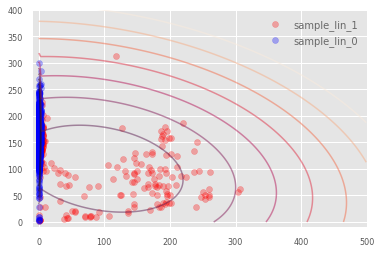

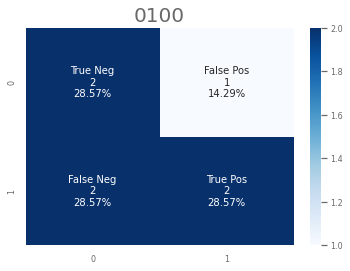

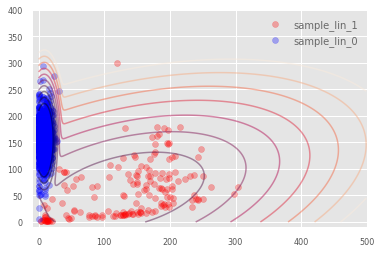

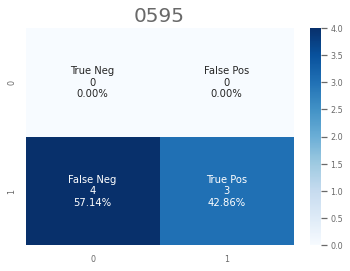

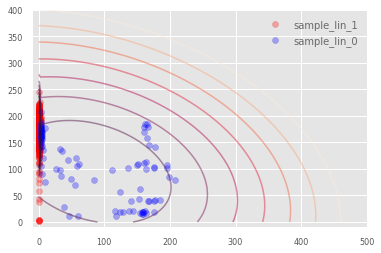

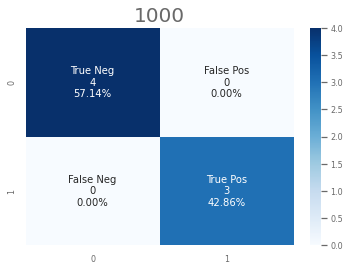

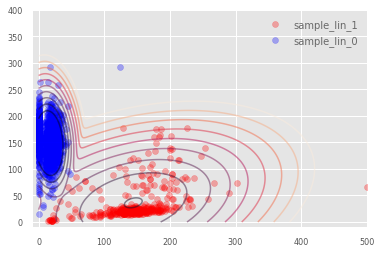

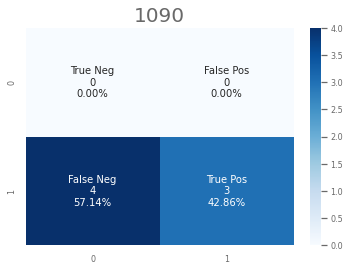

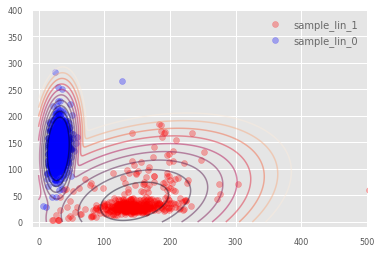

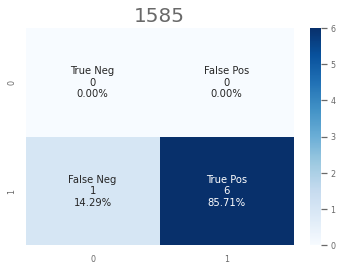

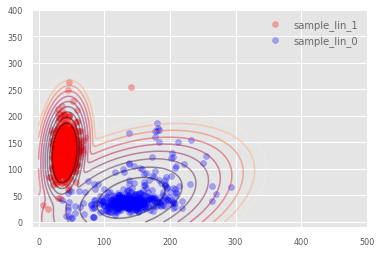

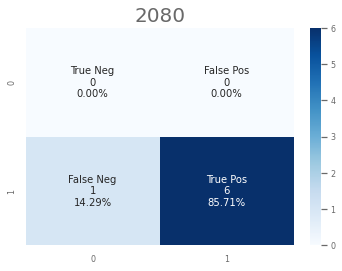

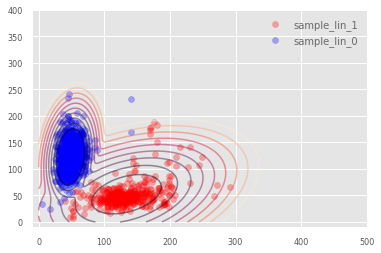

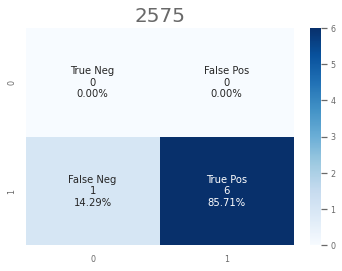

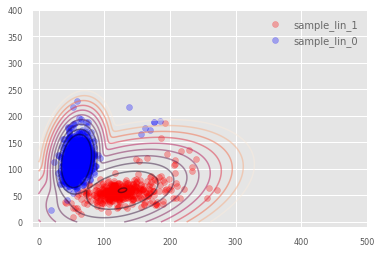

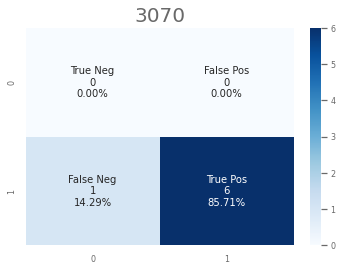

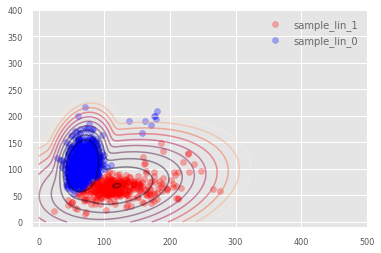

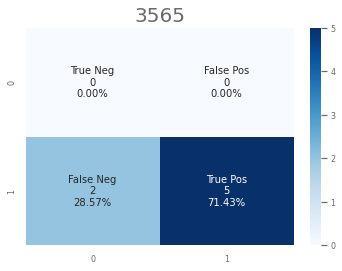

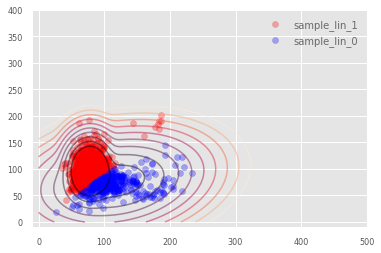

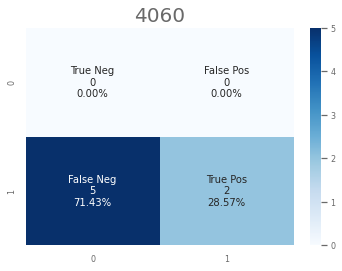

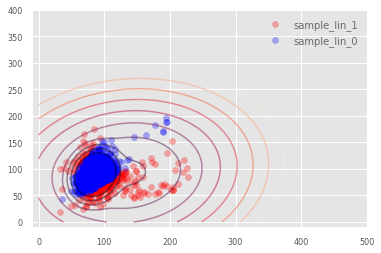

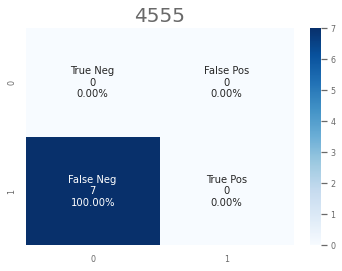

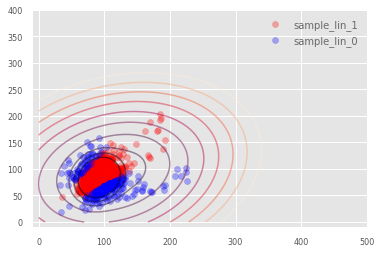

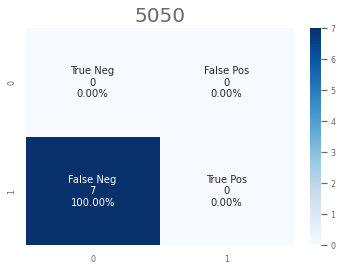

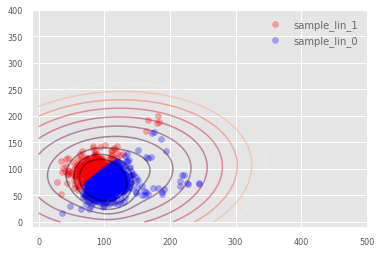

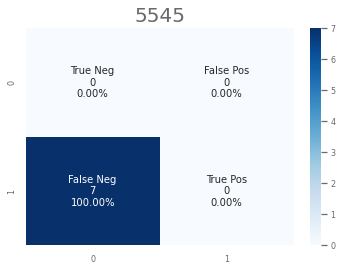

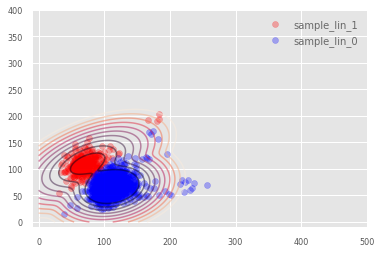

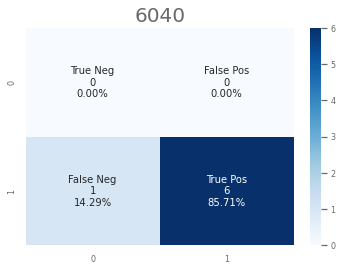

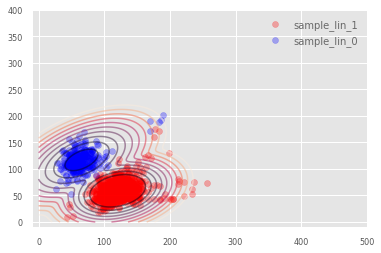

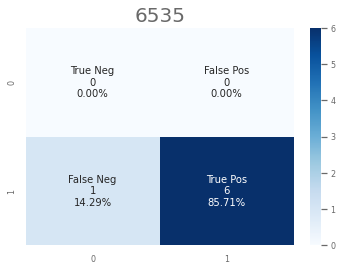

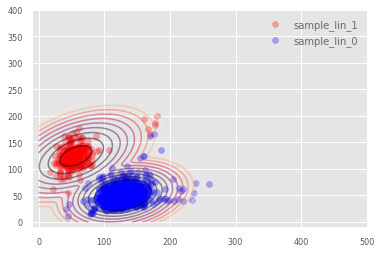

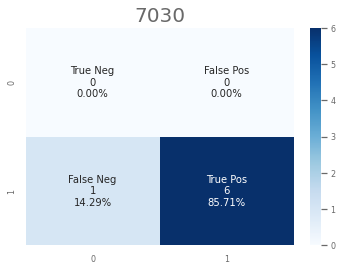

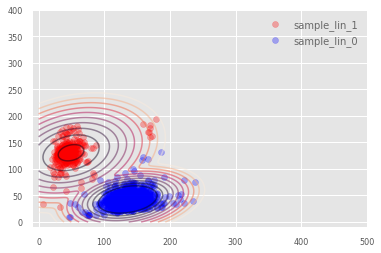

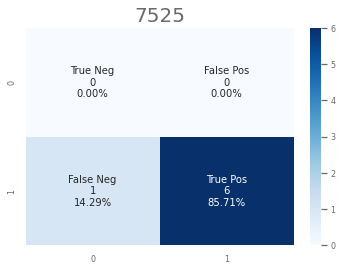

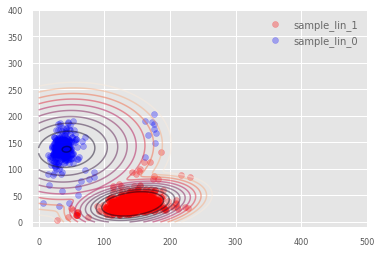

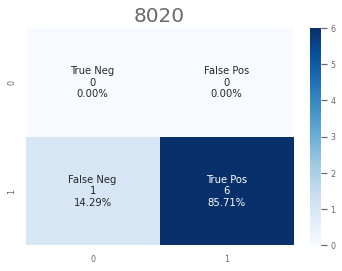

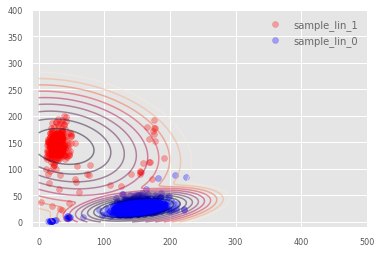

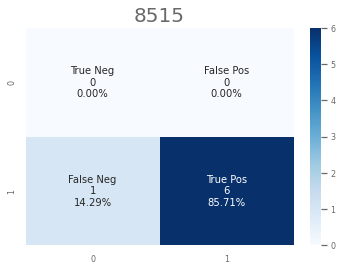

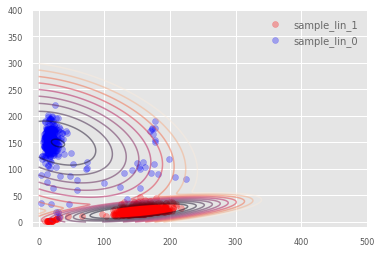

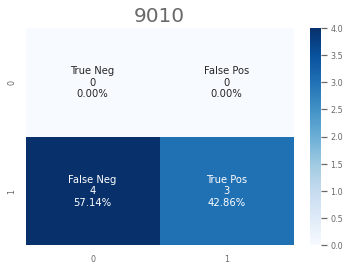

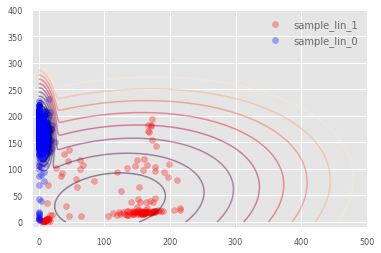

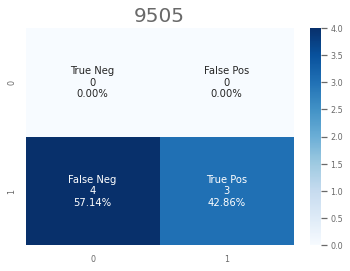

In [43]:
confusion_mat(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH, output=True)

In [34]:
def plot_gm(gm,data):
    gm.covariances_[0][0][0]
    std0 = np.sqrt(gm.covariances_[0][0][0]) #(n_components, n_features, n_features)
    print('std0:',std0)
    mu0 = gm.means_[0][0]
    print(mu0)
    std1 = np.sqrt(gm.covariances_[1][0][0]) #component 1?
    print('std1:',std1)
    mu1 = gm.means_[1][0]
    print(mu1)
    x = np.linspace(0, 1, 100)
    p0 = norm.pdf(x, mu0, std0)
    p1 = norm.pdf(x, mu1, std1)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Histogram(x=[x[0] for x in data]),secondary_y=False)
    fig.add_trace(go.Scatter(x=x, y=p0, mode='lines'),secondary_y=True)
    fig.add_trace(go.Scatter(x=x, y=p1, mode='lines'),secondary_y=True)
    fig.show()

In [35]:
def plot_gaussian():
    pos = []
    freqs = []
    with open('mix_infection.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe

    with open('mix_infection.csv', 'r') as f:
        for l in f:
            row = l.strip().split()
            ads = [int(x) for x in row[4].split(",")]
            afs = [x/sum(ads) for x in ads]
            pos.append(int(row[0]))
            freqs.append([afs[1]])

        mean_ = np.mean([x[0] for x in freqs])
        std_ = np.std([x[0] for x in freqs])
        print('mean:', mean_)
        print('std:', std_)
        print('2sd up', mean_-2*std_)
        print('2sd down', mean_+2*std_)

        print('skew:', skew([x[0] for x in freqs]))
        print('kurtosis:', kurtosis([x[0] for x in freqs]))


        fig = make_subplots()
        fig.add_trace(go.Histogram(x=[x[0] for x in freqs]),secondary_y=False)
        fig.add_vline(mean_-2*std_, line_dash='dash',line_color='red')
        fig.add_vline(mean_+2*std_, line_dash='dash',line_color='red')

        fig.show()



In [ ]:
plot_gaussian()

In [36]:
def vcf_to_mix_model(vcf_file,plot=False,tail_cutoff=0.05,title="AF Histogram",return_freqs = False):
    pos = []
    freqs = []
    with open('mix_infection.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe

    with open('mix_infection.csv', 'r') as f:
        for l in f:
            row = l.strip().split()
            ads = [int(x) for x in row[4].split(",")]
            afs = [x/sum(ads) for x in ads]
            if afs[1]>1-tail_cutoff or afs[1]<tail_cutoff:
                continue
            pos.append(int(row[0]))
            freqs.append([afs[1]])
        # freqs = [[0.7],[0.6],[0.4]]    
    gm = GaussianMixture(n_components=2, random_state=0).fit(freqs)
    if plot:
        plot_gm(gm,freqs)
    if return_freqs:
        return (gm,list(zip(pos,freqs)))
    else:
        return gm



In [ ]:
gm = vcf_to_mix_model(vcf_file,plot=True,tail_cutoff=0.1)


In [ ]:
json_results = json.load(open(json_file))
strain0 = []
strain1 = []
strainU = []

for var in json_results['dr_variants']:
    cluster = assign_variant_to_distrib(gm,var['freq'])
    if cluster[0] == 0:
        var['probs']= cluster
        strain0.append(var)
    elif cluster[0] == 1:
        var['probs']= cluster
        strain1.append(var)
    else:
        var['probs']= cluster[1:]
        strainU.append(var)

In [ ]:
print([(v['gene'],v['change'],v['freq'],v['probs']) for v in strain0])
for x in strain0:
    for y in x['drugs']:
        print(y['drug'])

In [ ]:
print([(v['gene'],v['change'],v['freq'],v['probs']) for v in strain1])
for x in strain1:
    for y in x['drugs']:
        print(y['drug'])


In [ ]:
print([(v['gene'],v['change'],v['freq'],v['probs']) for v in strainU])
for x in strainU:
    for y in x['drugs']:
        print(y['drug'])